# TP4: Travail Final 
## VANBELLE Julien

## Imports

In [ ]:
## nltk
import nltk
from nltk.corpus import stopwords
from nltk.corpus import webtext
from nltk import word_tokenize
from nltk.tokenize import wordpunct_tokenize
nltk.download('stopwords')
nltk.download('webtext')
## sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
## spacy
import spacy
from spacy.lang.fr.examples import sentences
## textblob
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
## gensim
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
## misc
from IPython.display import Image
from collections import defaultdict
from tabulate import tabulate
from datetime import datetime
import re
from unidecode import unidecode
import os
import collections
import string
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## dir
data_path = '/Users/julienvanbelle/Documents/GitHub/tac/data'
txt_path = data_path + '/txt'


## Data cleaning

In [ ]:
files = os.listdir(txt_path)
data_bxl = [f for f in files if f.startswith('Bxl_')]
len(data_bxl)


In [ ]:
data_list = []
for txt in data_bxl:
    with open(os.path.join(txt_path, txt), 'r', encoding = "ISO-8859-1") as f:
         data_list.append(f.read())

len(data_list)

In [ ]:
# Ecrire tout le contenu dans un fichier temporaire pour le nettoyer des stopwords propre au corpus
if not os.path.exists(data_path):
    os.mkdir(data_path)
with open(os.path.join(data_path, f'_temp.txt'), 'w') as f:
    f.write(' '.join(data_list))
    print("temp file saved in",data_path)

In [ ]:
wt_words = webtext.words('{}/_temp.txt'.format(data_path))
data_analysis = nltk.FreqDist(wt_words)
 
filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 3])
data_analysis = nltk.FreqDist(filter_words)
data_analysis.plot(30, cumulative=False)

In [ ]:
addsw = []
for z in sorted(filter_words):
  if filter_words[z] > 25000:
   addsw.append(z)

##print(addsw)

In [ ]:
# Stopwords
swLower = ' '.join(str(e).lower() for e in addsw)
sw = stopwords.words("french")
sw += stopwords.words("dutch")
sw += addsw
sw += swLower
sw += "conseil communal", "conseil général", "conseil supérieur", "administration communale", "conseil provincial", "l'administration communale", "conseil", "echevin" , "messieurs", "bruxelles", "bourgmestre", "collège", "être", "prã", "collã", "van", "ãªtre", "crã", "dit","intã" , "annã", "sociã","mãªme", "aprã", "penses", "pense", "considã", "trã", "cembre","elles","alors","rant","res","faite","cole","tat","ance","ment","non","vrier","sident","pital","tait","cet","etc"
sw = set(sw)
##print(sw)

In [ ]:
def clean_text(u, folder=None):
    if folder is None:
        input_path = f".txt"
        output_path = f"_clean.txt"
    else:
        ##for u in data_bxl:
            input_path = f"{folder}" + "/" + u
            output_path = data_path + "/txt_cleaned/" + "Clean_" + u ##opti ici avec {folder}
            ##print("Cleaning ==> " +u)
    
            output = open(output_path, "w", encoding="ISO-8859-1")
            with open(input_path, encoding="ISO-8859-1") as g:
                text = g.read()
                words = nltk.wordpunct_tokenize(text)
                kept = [w.lower() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw and "ã" not in w.lower()]
                kept_string = " ".join(kept)
                output.write(kept_string)
            return f'Output has been written in {data_path + "/txt_cleaned"}!'

In [ ]:

if not os.path.exists(data_path +"/txt_cleaned"):
    os.mkdir(data_path + "/txt_cleaned")
for x in data_bxl:
    clean_text(x, folder=txt_path)

In [ ]:
# Vérifier le résultat
with open(os.path.join(data_path + "/txt_cleaned/" + "Clean_" + data_bxl[0]), 'r', encoding="ISO-8859-1") as f:
    after = f.read()

after[:5000]

In [ ]:
clean_path = data_path + "/txt_cleaned/"

clean_files = os.listdir(clean_path)
clean_list = []
for j in clean_files:
    with open(os.path.join(clean_path, j), 'r', encoding = "ISO-8859-1") as f:
        clean_list.append(f.read())

len(clean_list)

## Répartition du corpus en clusters

### TF/IDF

In [ ]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

In [ ]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

In [ ]:
%time tfidf_vectors = vectorizer.fit_transform(clean_list)

In [ ]:
# Détail de la matrice
tfidf_vectors

In [ ]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

### K-means

In [ ]:
N_CLUSTERS = 3

km_model = KMeans(n_clusters=N_CLUSTERS)

In [ ]:
clusters = km_model.fit_predict(tfidf_vectors)

In [ ]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(clean_list[idx])

### Visualisation des clusters

In [ ]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [ ]:
reduced_vectors[:10]

In [ ]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

## WordClouds des clusters

In [141]:
cluster_count1 = word_tokenize(str(list(clustering[0])))
frequencies1 = Counter(cluster_count1)

cluster_count2 = word_tokenize(str(list(clustering[1])))
frequencies2 = Counter(cluster_count2)

cluster_count3 = word_tokenize(str(list(clustering[2])))
frequencies3 = Counter(cluster_count3)

### Cluster n°1

WordCloud du cluster n°1


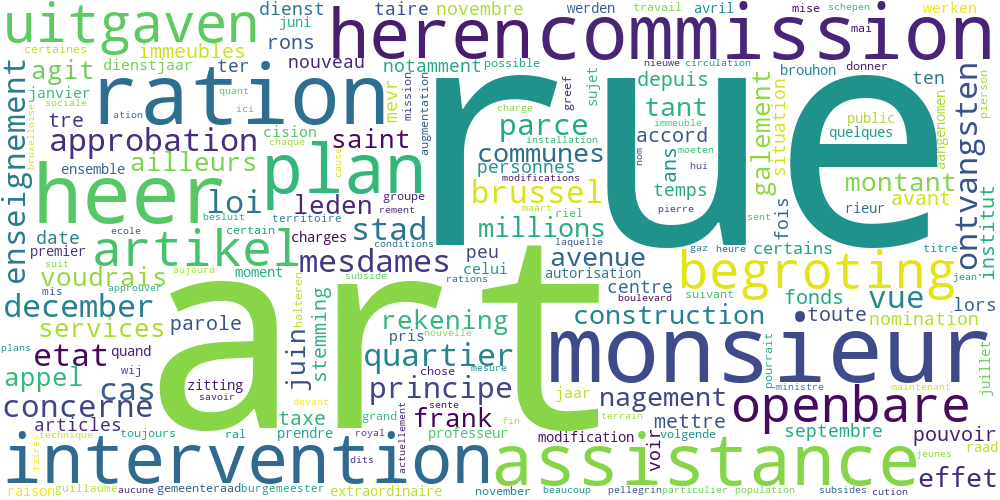

In [142]:
cloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(frequencies1)
cloud.to_file(os.path.join(data_path, "cluster1.png"))
print("WordCloud du cluster n°1")
Image(filename=os.path.join(data_path, "cluster1.png"))

### Cluster n°2

WordCloud du cluster n°2


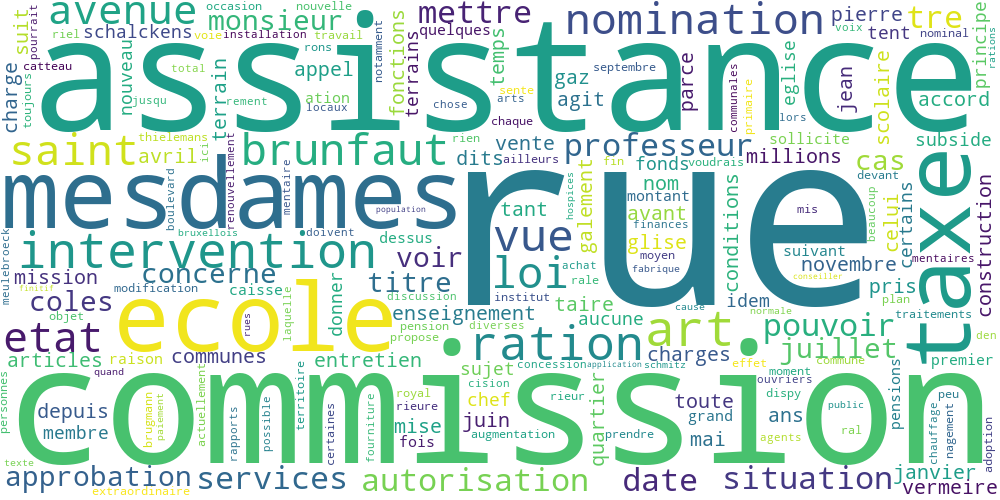

In [143]:
cloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(frequencies2)
cloud.to_file(os.path.join(data_path, "cluster2.png"))
print("WordCloud du cluster n°2")
Image(filename=os.path.join(data_path, "cluster2.png"))

### Cluster n°3

WordCloud du cluster n°3


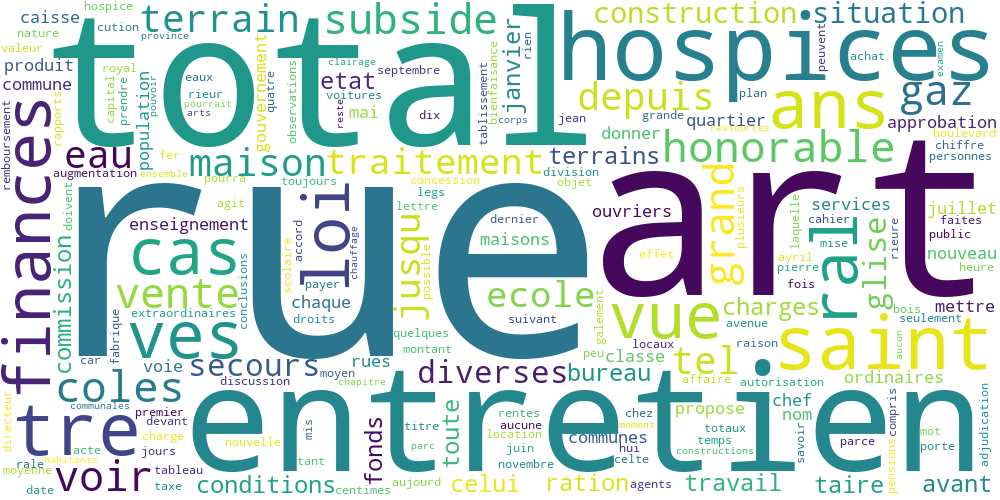

In [144]:

cloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(frequencies3)
cloud.to_file(os.path.join(data_path, "cluster3.png"))
print("WordCloud du cluster n°3")
Image(filename=os.path.join(data_path, "cluster3.png"))

## Analyse de la thématique des tramways bruxellois

### Apparition du terme "tramways" dans le corpus

In [ ]:
tramdoc = []
def check_if_exists(x, ls, r):
    if x in ls:
        tramdoc.append(r)

cleanNum = os.listdir(clean_path)

for q in cleanNum:
    with open(os.path.join(clean_path, q), 'r', encoding = "ISO-8859-1") as j:
         jlist = [(j.read())]
         word_tokenize(str(jlist))
         jstring = ''.join(str(jlist))
         
         check_if_exists('tramways', jstring, q)
 
      
print("Searching process done !")
print("The word is present in "+ str(len(tramdoc)) + "/" + str(len(clean_list)) + " documents")
print("The word appears in "+ str(tramdoc))

### Création d'un directory contenant les documents qui comportent le mot "tramways"

In [ ]:
if not os.path.exists(data_path +"/tramwaysRelated"):
    os.mkdir(data_path + "/tramwaysRelated")

for t in tramdoc:
  tramOut = open(data_path + "/tramwaysRelated/" + t, "w", encoding="ISO-8859-1")
  with open(clean_path+"/"+t, encoding="ISO-8859-1") as l:
      textTram = l.read()
      tramOut.write(textTram)

tram_path = data_path + "/tramwaysRelated"
print(str(len(os.listdir(tram_path)))+ " documents are saved in the /tramwaysRelated folder !")

### Création d'un fichier "all" contenant l'ensemble du corpus réduit "tramways"

In [ ]:
# Ecrire tout le contenu dans un fichier temporaire
if not os.path.exists(data_path):
    os.mkdir(data_path)

output = open(os.path.join(data_path, "tramAll.txt"), 'w')
for d in tramdoc:
 with open(os.path.join(clean_path, d), 'r', encoding = "ISO-8859-1") as k:
     klist = [(k.read())]
     output.write(''.join(klist))
     
print("temp file saved in",data_path)

### Visualisation du pourcentage de documents contenant le mot "tramways" dans le corpus

In [ ]:
a = len(tramdoc)
b = len(clean_list)
x = (a / b)*100
print(str(int(x)) + "% of the documents in the corpus contains the word : 'tramways'")

labels = '"tramways" related docs ', 'Others'
sizes = [x,(100-x)]
colors = ['yellowgreen', 'gold']

plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.show()

### Date d'apparition dans le corpus

In [ ]:
import re
from datetime import datetime
res = []

for d in tramdoc:
   datestring = ''.join(str(d))
   match_str = re.search(r'\d{4}', datestring)
   res.append(datetime.strptime(match_str.group(), '%Y').date())

res.sort()
# printing result
print("The word " +"'"+"tramways"+"' "+"first appear in the year : " + str(res[0])[0:4])


### TF/IDF du mot "tramways" dans le corpus

In [ ]:
# our corpus
data = clean_list

cv = CountVectorizer()

# convert text data into term-frequency matrix
data = cv.fit_transform(data)

tfidf_transformer = TfidfTransformer()

# convert term-frequency matrix into tf-idf
tfidf_matrix = tfidf_transformer.fit_transform(data)

# create dictionary to find a tfidf word each word
word2tfidf = dict(zip(cv.get_feature_names(), tfidf_transformer.idf_))

In [ ]:
dictionary = dict(word2tfidf)
search_word = "tramways"
for word, score in dictionary.items():
    if search_word in dictionary:
        print("TF/IDF score of: "+ "'"+ search_word + "'" + " is " + str(score))
        break

### Recherche des entités nommées présentes dans les documents qui parlent du tramways

In [ ]:
nlp = spacy.load('fr_core_news_md')

In [ ]:
# Charger le texte
n=980000
text = open(data_path + "/" + "tramAll.txt", encoding="ISO-8859-1").read()[:n]

In [ ]:
%%time
# Traiter le texte

doc = nlp(text)

In [ ]:
# Compter les entités
people = defaultdict(int)
organisation = defaultdict(int)
places = defaultdict(int)

for ent in doc.ents:
    if ent.label_ == "PER" and len(ent.text) > 3:
        people[ent.text] += 1
    if ent.label_ == "ORG" and len(ent.text) > 3:
        organisation[ent.text] += 1
    if ent.label_ == "LOC" and len(ent.text) > 3:
        places[ent.text] += 1
      

In [ ]:
# Trier et imprimer

sorted_people = sorted(people.items(), key=lambda kv: kv[1], reverse=True)
sorted_organisation = sorted(organisation.items(), key=lambda kv: kv[1], reverse=True)
sorted_places = sorted(places.items(), key=lambda kv: kv[1], reverse=True)


for person, freq in sorted_people:
    print(f"{person} (PER)apparait {freq} fois dans le corpus")

for organisation, freq in sorted_organisation:
    print(f"{organisation} (ORG)apparait {freq} fois dans le corpus")

for places, freq in sorted_places:
    print(f"{places} (LOC)apparait {freq} fois dans le corpus")

## Wordcloud 

### Génération du WordCloud

In [ ]:
with open(os.path.join(data_path +"/"+"tramAll.txt" ), 'r') as f:
    after = f.read()

In [ ]:
frequencies = Counter(after.split())
print(frequencies.most_common(10))

In [ ]:
cloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(frequencies)
cloud.to_file(os.path.join(data_path, "tram.png"))
Image(filename=os.path.join(data_path, "tram.png"))

## Word2Vec sur le corpus réduit

In [ ]:
##Sentences tokenization 
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding="ISO-8859-1", errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [ ]:
infile = data_path+"/"+"tramAll.txt"
sentences = MySentences(infile)

In [ ]:
bigram_phrases = Phrases(sentences)

In [ ]:
type(bigram_phrases.vocab)

In [ ]:
len(bigram_phrases.vocab.keys())

In [ ]:
key_ = list(bigram_phrases.vocab.keys())[144]
print(key_)

In [ ]:
bigram_phrases.vocab[key_]

In [ ]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

### Analyse des trigrams

In [ ]:
trigram_phrases = Phrases(bigram_phraser[sentences])

In [ ]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

In [ ]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

In [ ]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

### Entrainement de Word2Vec

In [ ]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=10, # La taille du "contexte", ici 6 mots avant et après le mot observé
    min_count=10, # On ignore les mots qui n'apparaissent pas au moins 10 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

### Sauvegarde du modèle

In [ ]:
outfile = f"../data/bulletinsTram.model"
model.save(outfile)

In [ ]:
model = Word2Vec.load("../data/bulletinsTram.model")

## Exploration du modèle Word2Vec

### Similarity

In [ ]:
model.wv.similarity("depenses", "tramways")

In [ ]:
model.wv.similarity("travail", "tramways")

In [ ]:
model.wv.similarity("transport", "tramways")

In [ ]:
model.wv.similarity("engin", "tramways")

In [ ]:
model.wv.similarity("rue", "tramways")

In [ ]:
model.wv.similarity("rail", "tramways")

In [ ]:
model.wv.similarity("voie", "tramways")

In [ ]:
model.wv.similarity("route", "tramways")

### Most Similar

In [ ]:
model.wv.most_similar("tramways", topn=10)

In [ ]:
model.wv.most_similar("travail", topn=10)

In [ ]:
model.wv.most_similar("tram", topn=10)

In [ ]:
model.wv.most_similar("transport", topn=10)

In [ ]:
model.wv.most_similar("rail", topn=10)

## Analyse de sentiments 

### Isolation des phrases qui contiennent le mot "tramways"

### Fonctions 

In [ ]:

tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

def get_sentiment(input_text):
    blob = tb(input_text)
    polarity, subjectivity = blob.sentiment
    polarity_perc = f"{100*abs(polarity):.0f}"
    subjectivity_perc = f"{100*subjectivity:.0f}"
    if polarity > 0:
        polarity_str = f"{polarity_perc}% positive"
    elif polarity < 0:
        polarity_str = f"{polarity_perc}% negative"
    else:
        polarity_str = "neutral"
    if subjectivity > 0:
        subjectivity_str = f"{subjectivity}% subjective"
    else:
        subjectivity_str = "perfectly objective"
    print(f"This text is {polarity_str} and {subjectivity_str}.")

In [ ]:
get_sentiment()

## Génération d'un tableau récapitulatif des informations extraites du coprus

In [ ]:
print(tabulate(score_list,headers='firstrow',tablefmt='fancy_grid'))